In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import sys, os
import gpt3_functions

## **Transformation** dans un autre domaine

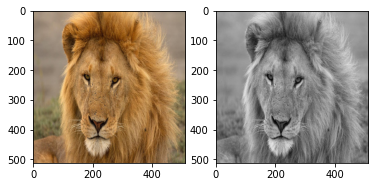

In [61]:
# Chargement de l'image
filename = './figures/06.png'
IMAGE_bgr = cv2.imread(filename)
IMAGE_rgb = cv2.cvtColor(IMAGE_bgr, cv2.COLOR_BGR2RGB)
IMAGE_nb = cv2.cvtColor(IMAGE_rgb, cv2.COLOR_RGB2GRAY)
[H,W] = IMAGE_nb.shape

plt.subplot(121)
plt.imshow(IMAGE_rgb)
plt.subplot(122)
plt.imshow(IMAGE_nb, cmap='gray')
cv2.imwrite('06_nb.png', IMAGE_nb)


plt.show()

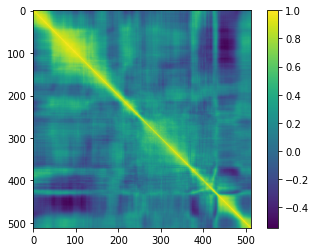

In [62]:
mat_corr = np.corrcoef(IMAGE_nb)
plt.imshow(mat_corr)
plt.colorbar()
plt.show()

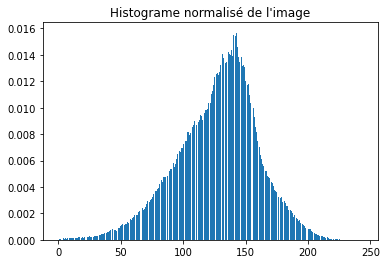

In [63]:
hist_IMAGE_nb, bin_edges_IMAGE_nb = np.histogram(IMAGE_nb, bins=255)
bin_edges_IMAGE_nb = bin_edges_IMAGE_nb[:-1:]
hist_IMAGE_nb_normalise = hist_IMAGE_nb / (H*W) 
plt.bar(bin_edges_IMAGE_nb, hist_IMAGE_nb_normalise)
plt.title('Histograme normalisé de l\'image')
plt.show()
# plt.plot(bin_edges_IMAGE_nb, hist_IMAGE_nb)


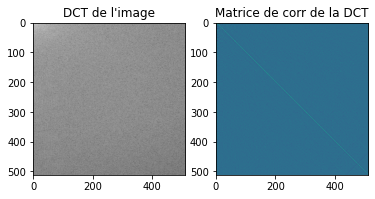

In [64]:
# Transformation - DCT - Dicrete Cosinus Transform
IMAGE_DCT = cv2.dct(IMAGE_nb.astype(float))
mat_corr_dct = np.corrcoef(IMAGE_DCT)

plt.subplot(121)
plt.imshow(np.log(np.abs(IMAGE_DCT)), 'gray')
plt.title('DCT de l\'image' )
plt.subplot(122)
plt.imshow(mat_corr_dct)
plt.title('Matrice de corr de la DCT')
plt.show()

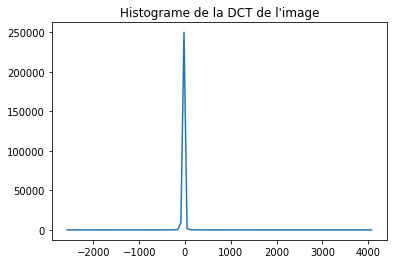

In [65]:
# hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT, bins=1000)

IMAGE_DCT_sansMin = np.copy(IMAGE_DCT)
IMAGE_DCT_sansMin[0][0] = 0
hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT_sansMin, bins=100)

bin_edges_IMAGE_DCT = bin_edges_IMAGE_DCT[:-1:]
plt.plot(bin_edges_IMAGE_DCT, hist_IMAGE_DCT)
plt.title('Histograme de la DCT de l\'image')
plt.show()

## **Codage** et **quantification** des coefficients

In [66]:
# separate IMAGE_nb into 8x8 blocks
def decoupage88_copilot(mat):
    listImages88 = list()
    for i in range(0, W, 8):
        for j in range(0, H, 8):
            imagette = mat[i:i+8, j:j+8]
            listImages88.append(imagette)
    return listImages88
# reconstruct IMAGE_nb from 8x8 blocks
def reconstruct88_copilot(pList):
    pList_tmp = np.copy(pList).tolist()
    mat = np.zeros((H,W))
    for i in range(0, W, 8):
        for j in range(0, H, 8):
            mat[i:i+8, j:j+8] = pList_tmp.pop(0)
    return mat

In [67]:
# Decoupage de l'image
listImages88 = decoupage88_copilot(IMAGE_nb)
listImage88 = gpt3_functions.divide_image(IMAGE_nb)

In [68]:
# Calcul DCT par bloc 
listImages88DCT = list()
for imagette in listImages88:
    foo = cv2.dct(imagette.astype(float))
    listImages88DCT.append( foo )
    

### **Quantification**

In [69]:
Z = [[16, 11, 10, 16, 24,  40,  51,  61],
     [12, 12, 14, 19, 26,  58,  60,  55],
     [14, 13, 16, 24, 40,  57,  69,  56],
     [14, 17, 22, 29, 51,  87,  80,  62],
     [18, 22, 37, 56, 68,  109, 103, 77],
     [24, 35, 55, 64, 81,  104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]]
Z = np.ones((8,8))
Z = np.array(Z)

T_hat = list()
T_hat_posNonNul = list()

for T in listImages88DCT:
     # tmp = (T/Z).round().astype(int)
     tmp = (T/Z)
     T_hat.append( tmp )
     position = np.where(np.abs(tmp)>0,1,0)
     T_hat_posNonNul.append(position)


### **Codage**

In [70]:
def zigzag(a):
    # returnList = list()
    # returnList = np.concatenate( [np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0]) ] )
    listtmp = []
    # print(f'a = {a}')
    for i in range(1-a.shape[0], a.shape[0]):
        # print(f'i = {i}')
        # print(f'np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] = {np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)]}')
        diag = np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)]
        listtmp.append(diag) 
    returnList = np.concatenate(listtmp)
    return returnList

In [71]:
# Parcours en zigzag de chaque DFT 8x8
CODE_values = list()
CODE_position = list()
for (imagette,position) in zip(T_hat,T_hat_posNonNul):
    codeBloc = zigzag(imagette)  
    codePosition = zigzag(position) 
    codePosition2 = ''.join(map(str, codePosition))
    # print(codePosition2)
    CODE_values.append(codeBloc) 
    CODE_position.append(codePosition2)


In [72]:
def run_length_encode(input_str):
    run_length_encoded_string = []
    current_run_length = 1
    # Perform a run length encoding of input_str
    for i in range(1, len(input_str)):
        current_char = input_str[i]
        previous_char = input_str[i-1]
        if current_char != previous_char or current_run_length == 9:
            run_length_encoded_string.append(str(current_run_length))
            run_length_encoded_string.append(previous_char)
            current_run_length = 0
        current_run_length += 1
    # Handle any remaining character
    run_length_encoded_string.append(str(current_run_length))
    run_length_encoded_string.append(input_str[len(input_str)-1])
    return "".join(run_length_encoded_string)

In [73]:
# codage par plage pour enchainer les positions non nulles 
CODE_position_parPlage = list()
for position in CODE_position:
    codageParPlage = run_length_encode(position)
    CODE_position_parPlage.append(codageParPlage)
    # print(position)
    # print(codageParPlage)

In [74]:
def toBinary4bit(nb):
    if type(nb) != int:
        print('INVALID VARIABLE TYPE')
        return False
    else : 
        if nb < 0 or nb > 9:
            print('INVALID NUMBER')
            return False
        if nb >= 0 and nb <= 9 :
            binary = bin(nb)
            binary = binary[2::]
            binary = binary.zfill(4)
            return binary

In [75]:
def codageBinaireDuCodeParPlage(str):
    BINARY = ''
    for char in str:
        foo = toBinary4bit(int(char))
        BINARY += foo
    return BINARY

In [76]:
# tmp = CODE_position_parPlage[0]
# print(tmp)
# BIN = codageBinaireDuCodeParPlage(tmp)
# print(BIN)

In [77]:
flagBLOC = 'B'
flagVAL = 'V'
flagVAL2POS = 'P'

def codageBLOC(arrValues, strPosition):
    flagBLOC = 'B'
    flagVAL = 'V'
    flagVAL2POS = 'P'
    total_code = ''

    values = arrValues[arrValues!=0]
    strValues = flagVAL.join(values.astype(str))
    # print(strValues)
    total_code += strValues
    total_code += flagVAL2POS
    total_code += strPosition
    total_code += flagBLOC
    # print(total_code)
    return total_code

# tmp = codageBLOC(T_hat[0], CODE_position_parPlage[0])
# print(tmp)

In [78]:
test = ''
for i in range(0,5):
    foo = codageBLOC(T_hat[i], CODE_position_parPlage[i])
    # print(foo)
    test += foo

with open('compressed.txt', 'w') as file:
    for (arrValues, strPosition) in zip(T_hat, CODE_position_parPlage):
        bloc = codageBLOC(arrValues, strPosition)
        file.write(bloc)

## **Décodage** et **décompression** de l'image

#### processus inverse :
- lire fichier 
- ecire fichier dans str
- split par bloc
- split valeurs et position
- split valeurs
- décoder zigzag
- créer image T_hat 
- opération avec Z 
- concat de toutes les imagettes 

In [79]:
with open('compressed.txt', 'r') as file:
    stringTot = file.read()
listBloc = stringTot.split(flagBLOC)
_ = listBloc.pop()

In [94]:
def decodeBLOC(strBLOC):
    tmp = strBLOC.split(flagVAL2POS)
    values = tmp[0]
    pos = tmp[1]
    values = values.split(flagVAL)
    values = np.array(values)
    # string to int 
    values = values.astype(float).astype(int)
    return values, pos

In [81]:
def decodeCodeParPlage(str):
    arrPosNonNulles = []
    for i in range(0,len(str), 2):
        for k in range(0,int(str[i])):
            arrPosNonNulles.append( int(str[i+1]) )        
    return np.array(arrPosNonNulles)

In [82]:
def zeroPaddingArrValues(arrValues, arrPosition):
    arrZZfullLenght = np.zeros((8*8,))

    for k in range(len(arrValues)):
        if arrPosition[k] :
            arrZZfullLenght[k] = arrValues[k] 
    arrZZfullLenght = arrZZfullLenght.astype(int)

    return arrZZfullLenght

In [83]:
# code in zigzag the values in a matrix 8 by 8
def zigzag_copilot(mat):
    returnList = []
    for i in range(1-mat.shape[0], mat.shape[0]):
        diag = np.diagonal(mat[::-1,:], i)[::(2*(i % 2)-1)]
        returnList.append(diag) 
    return np.concatenate(returnList)

# undo the zigzag
# display the matrix after undoing the zigzag
# the zigzag is done like in the function zigzag_copilot
# we want to undo the zigzag
def unzigzag_copilot(arr):
    mat = np.zeros((8,8))
    mat[0,0] = arr[ 0]
    mat[1,0] = arr[ 1]
    mat[0,1] = arr[ 2]
    mat[0,2] = arr[ 3]
    mat[1,1] = arr[ 4]
    mat[2,0] = arr[ 5]
    mat[3,0] = arr[ 6]
    mat[2,1] = arr[ 7]
    mat[1,2] = arr[ 8]
    mat[0,3] = arr[ 9]
    mat[0,4] = arr[10]
    mat[1,3] = arr[11]
    mat[2,2] = arr[12]
    mat[3,1] = arr[13]
    mat[4,0] = arr[14]
    mat[5,0] = arr[15]
    mat[4,1] = arr[16]
    mat[3,2] = arr[17]
    mat[2,3] = arr[18]
    mat[1,4] = arr[19]
    mat[0,5] = arr[20]
    mat[0,6] = arr[21]
    mat[1,5] = arr[22]
    mat[2,4] = arr[23]
    mat[3,3] = arr[24]
    mat[4,2] = arr[25]
    mat[5,1] = arr[26]
    mat[6,0] = arr[27]
    mat[7,0] = arr[28]
    mat[6,1] = arr[29]
    mat[5,2] = arr[30]
    mat[4,3] = arr[31]
    mat[3,4] = arr[32]
    mat[2,5] = arr[33]
    mat[1,6] = arr[34]
    mat[0,7] = arr[35]
    mat[1,7] = arr[36]
    mat[2,6] = arr[37]
    mat[3,5] = arr[38]
    mat[4,4] = arr[39]
    mat[5,3] = arr[40]
    mat[6,2] = arr[41]
    mat[7,1] = arr[42]
    mat[7,2] = arr[43]
    mat[6,3] = arr[44]
    mat[5,4] = arr[45]
    mat[4,5] = arr[46]
    mat[3,6] = arr[47]
    mat[2,7] = arr[48]
    mat[3,7] = arr[49]
    mat[4,6] = arr[50]
    mat[5,5] = arr[51]
    mat[6,4] = arr[52]
    mat[7,3] = arr[53]
    mat[7,4] = arr[54]
    mat[6,5] = arr[55]
    mat[5,6] = arr[56]
    mat[4,7] = arr[57]
    mat[5,7] = arr[58]
    mat[6,6] = arr[59]
    mat[7,5] = arr[60]
    mat[7,6] = arr[61]
    mat[6,7] = arr[62]
    mat[7,7] = arr[63]
    return mat

In [84]:
import gpt3_functions
def decodeZZ(arrZZval, arrZZpos):
    imagette = np.zeros((8,8))
    arrZZfullLenght = zeroPaddingArrValues(arrZZval, arrZZpos)
    imagette = unzigzag_copilot(arrZZfullLenght)
    # imagette = gpt3_functions.unzigzag(arrZZfullLenght)
    # for k in range(0,8):
    #     col = k
    #     print(f'decode zz k = {k}')
    #     for i in range(k+1):
    #         # print(f'decode zz i = {i}, col = {col}')
    #         if k%2 == 0:
    #             x1,x2 = col, i
    #             print(f'{(col,i)}')
    #         elif k%2 != 0:
    #             x1,x2 = i,col
    #             print(f'{(i,col)}')
    #         print(f'arrZZfullLenght[{i*8 + col}] = {arrZZfullLenght[i*8 + col]}')
            
    #         imagette[x1][x2] = arrZZfullLenght[k*8+i]
    #         col -= 1
    #     i = 0
        
    # print(f'imagette = \n {imagette}')
    # plt.imshow(imagette,'gray')
    # plt.show()
    return imagette

In [85]:
def reconstruction(imagette88):
    tmp = np.multiply(imagette88, Z)
    tmp = cv2.idct(tmp)
    # plt.imshow(tmp,'gray')
    # plt.show()
    return tmp

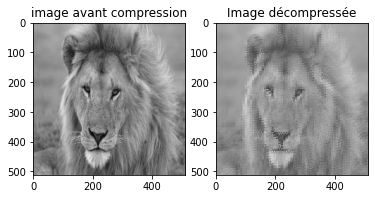

In [95]:
import gpt3_functions
listBlocrec = list()
for k,bloc in enumerate(listBloc):
    values,pos = decodeBLOC(bloc)
    # print(values)
    pos = decodeCodeParPlage(pos)
    imagette = decodeZZ(values,pos)
    imagette_rec = reconstruction(imagette)
    listBlocrec.append(imagette_rec)
Irec = np.zeros((H,W))
k = 0

Irec = reconstruct88_copilot(listBlocrec)
# for i in range(W//8):
#     for j in range(H//8):
#         Irec[i*8:(i+1)*8 , j*8:(j+1)*8] = listBlocrec[k]
#         k+=1

plt.subplot(121)
plt.imshow(IMAGE_nb, 'gray')
plt.title('image avant compression')
plt.subplot(122)
plt.imshow(Irec,'gray')
plt.title('Image décompressée')
plt.show()

_ = cv2.imwrite('figure_06_compressed.png', Irec)

In [ ]:
# Mesure de la dégradation
MSE = np.mean((Irec - IMAGE_nb)**2)
print(f'MSE = {round(MSE, 2)}')

size_init = round(sys.getsizeof(IMAGE_nb)/1024, 2)
size_comp = round(sys.getsizeof(listBloc)/1024, 2)
print(f' Size in Kbyte of the image = {size_init} Kbyte')
print(f' Size in Kbyteof the image after compression = {size_comp} Kbyte')

compressionRatio = sys.getsizeof(IMAGE_nb)/sys.getsizeof(listBloc)
print(f' Compression ratio = {round(compressionRatio, 2)}')

MSE = 378.91
 Size in Kbyte of the image = 256.12 Kbyte
 Size in Kbyteof the image after compression = 32.34 Kbyte
 Compression ratio = 7.92
